# EMA Crossover Strategy Backtester

This notebook implements an Exponential Moving Average (EMA) crossover trading strategy backtester for AMD stock data using hourly timeframes.

## Configuration
You can adjust the EMA parameters below by modifying these values:
- Short-term EMA period (default: 9 periods)
- Long-term EMA period (default: 20 periods)

These parameters only need to be changed in this notebook, and the changes will propagate through the entire system.

The implementation is structured in separate modules:
- `data_handler.py`: Handles data fetching and preprocessing
- `strategy.py`: Implements the EMA crossover strategy
- `backtester.py`: Executes the backtesting logic
- `performance_analyzer.py`: Analyzes and visualizes results

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime
from alpaca.data.timeframe import TimeFrame
import os
from dotenv import load_dotenv

# Import our custom modules
from src.data_handler import DataHandler
from src.strategy import EMAStrategy
from src.backtester import Backtester
from src.performance_analyzer import PerformanceAnalyzer

# Configure pandas display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Format all floats to 2 decimal places

# Load environment variables
load_dotenv()

# Get Alpaca API credentials from environment variables
API_KEY = os.getenv('ALPACA_API_KEY')
SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')

if not API_KEY or not SECRET_KEY:
    raise ValueError("Alpaca API credentials not found in environment variables. Please check your .env file.")

# Define the stock symbol to analyze
ticker = "AMD"

## 1. Load and Prepare Data

Initialize the DataHandler and load the AMD stock data. The data will be loaded from CSV if available, otherwise it will be fetched from the Alpaca API.

In [2]:
# Define EMA parameters (you can modify these values to change the strategy)
EMA_SHORT_PERIOD = 5
EMA_LONG_PERIOD = 20

# Initialize DataHandler
data_handler = DataHandler(API_KEY, SECRET_KEY, symbol=ticker)

# Try to load data from CSV first, if not available or invalid, fetch from API
data = data_handler.fetch_data(
    symbol=ticker,
    timeframe=TimeFrame.Hour,
    start=datetime(2022, 1, 1),
    end=datetime(2025, 8, 1)
)

# Add technical indicators using EMA with the configured periods
data = data_handler.add_technical_indicators(ema_short=EMA_SHORT_PERIOD, ema_long=EMA_LONG_PERIOD)

# Display the first few rows of data
print("\nData Information:")
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print("\nFirst few rows:")
display(data.head())

Successfully loaded data from /Users/yush/Documents/GitHub/ema_backtest/amd_data.csv
Data loaded from /Users/yush/Documents/GitHub/ema_backtest/amd_data.csv

Data Information:
Shape: (14188, 9)
Date range: 2022-01-03 09:00:00+00:00 to 2025-07-31 23:00:00+00:00

First few rows:


,open,high,low,close,volume,trade_count,vwap,EMA_short,EMA_long
timestamp,,,,,,,,,
2022-01-03 09:00:00+00:00,144.92,145.55,144.50,145.05,16105.00,464.00,145.06,145.05,145.05
2022-01-03 10:00:00+00:00,145.17,145.45,145.00,145.45,11422.00,303.00,145.23,145.18,145.09
2022-01-03 11:00:00+00:00,145.76,145.79,145.50,145.62,14519.00,312.00,145.62,145.33,145.14
2022-01-03 12:00:00+00:00,145.60,146.27,145.34,145.94,109354.00,1580.00,145.64,145.53,145.22
2022-01-03 13:00:00+00:00,145.40,146.10,145.12,145.18,243594.00,3234.00,145.70,145.42,145.21


## 2. Generate Trading Signals

Create an instance of our SMA strategy and generate trading signals based on the moving average crossovers.

In [3]:
# Initialize strategy with the configured EMA periods
strategy = EMAStrategy(ema_short=EMA_SHORT_PERIOD, ema_long=EMA_LONG_PERIOD)

# Generate signals
data = strategy.get_entry_conditions(data)

# Display a sample of the signals
display(data[['close', 'EMA_short', 'EMA_long', 'signal']].head(10))

,close,EMA_short,EMA_long,signal
timestamp,,,,
2022-01-03 09:00:00+00:00,145.05,145.05,145.05,0
2022-01-03 10:00:00+00:00,145.45,145.18,145.09,1
2022-01-03 11:00:00+00:00,145.62,145.33,145.14,0
2022-01-03 12:00:00+00:00,145.94,145.53,145.22,0
2022-01-03 13:00:00+00:00,145.18,145.42,145.21,0
2022-01-03 14:00:00+00:00,147.92,146.25,145.47,0
2022-01-03 15:00:00+00:00,151.16,147.89,146.01,0
2022-01-03 16:00:00+00:00,149.76,148.51,146.37,0
2022-01-03 17:00:00+00:00,150.07,149.03,146.72,0


## 3. Run Backtest

Initialize the backtester with our strategy and run it on the prepared data.

In [4]:
# Initialize and run backtester
backtester = Backtester(strategy, initial_capital=10000.0, position_size=8000.0)
portfolio = backtester.run(data)
trades = backtester.log_trades()

# Display the first few rows of the portfolio
print("\nPortfolio Summary:")
display(portfolio.head())
print("\nTrades Summary:")
display(trades.head())


Portfolio Summary:


,open,high,low,close,volume,trade_count,vwap,EMA_short,EMA_long,signal_crossover,...,signal_atr,signal,cash,holdings,total_value,trade_price,shares,pnl_trade,win_loss,portfolio_return_pct
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:00:00+00:00,144.92,145.55,144.50,145.05,16105.00,464.00,145.06,145.05,145.05,0,...,0,0,10000.00,0.00,10000.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 10:00:00+00:00,145.17,145.45,145.00,145.45,11422.00,303.00,145.23,145.18,145.09,1,...,0,1,2000.00,8000.00,10000.00,145.45,55.00,0.00,0.00,0.00
2022-01-03 11:00:00+00:00,145.76,145.79,145.50,145.62,14519.00,312.00,145.62,145.33,145.14,0,...,0,0,2000.00,8009.35,10009.35,0.00,0.00,0.00,0.00,0.09
2022-01-03 12:00:00+00:00,145.60,146.27,145.34,145.94,109354.00,1580.00,145.64,145.53,145.22,0,...,0,0,2000.00,8026.95,10026.95,0.00,0.00,0.00,0.00,0.27
2022-01-03 13:00:00+00:00,145.40,146.10,145.12,145.18,243594.00,3234.00,145.70,145.42,145.21,0,...,0,0,2000.00,7985.15,9985.15,0.00,0.00,0.00,0.00,-0.15



Trades Summary:


,open,high,low,close,volume,trade_count,vwap,EMA_short,EMA_long,signal_crossover,...,cash,holdings,total_value,trade_price,shares,pnl_trade,win_loss,portfolio_return_pct,value,pct_gain_loss
2022-01-03 10:00:00+00:00,145.17,145.45,145.00,145.45,11422.00,303.00,145.23,145.18,145.09,1.00,...,2000.00,8000.00,10000.00,145.45,55.00,0.00,0.00,0.00,8000.00,0.00
2022-01-04 15:00:00+00:00,149.27,149.48,143.10,143.12,17192314.00,137333.00,146.05,148.18,149.12,-1.00,...,9871.85,0.00,9871.85,143.12,0.00,-128.15,0.00,-1.28,0.00,-1.60
2022-01-07 11:00:00+00:00,137.21,137.48,136.98,137.20,8470.00,267.00,137.28,137.09,137.05,1.00,...,1871.85,8000.00,9871.85,137.20,58.31,0.00,0.00,-1.28,8000.00,0.00
2022-01-07 12:00:00+00:00,137.19,137.49,136.69,136.81,57105.00,1141.00,137.14,137.00,137.03,-1.00,...,9849.11,0.00,9849.11,136.81,0.00,-22.74,0.00,-1.51,0.00,-0.28
2022-01-10 22:00:00+00:00,132.35,132.40,132.02,132.30,492054.00,663.00,132.22,131.21,131.03,1.00,...,1849.11,8000.00,9849.11,132.30,60.47,0.00,0.00,-1.51,8000.00,0.00


## 4. Analyze Results

Calculate performance metrics and visualize the results.

In [5]:
# Initialize analyzer
analyzer = PerformanceAnalyzer(portfolio, trades, data)

# Calculate metrics
metrics = analyzer.analyze_trades()

# Print results
print("\nPerformance Metrics:")
print("===================")
for metric, value in metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.2f}%")
    else:
        print(f"{metric}: {value}")

# Generate and display trade report
trade_report = analyzer.generate_trade_report()
print("\nTrade Report:")
print("============")
display(trade_report.head().round(2))  # Ensure display shows rounded numbers

print("\nTrade Statistics:")
print("================")
stats = trade_report.describe()
display(stats.round(2))  # Round statistics as well


Performance Metrics:
Portfolio Return: 101.90%
Total Trade Returns: 127.36%
Sharpe Ratio: 1.12
Max Drawdown: -23.38%
Max Trade Return: 16.63%
Win Rate: 35.64%
Number of Trades: 376

Trade Report:


,entry_time,entry_price,exit_price,shares,profit,return_pct,duration,total_value,cumulative_profit,cumulative_return_pct
exit_time,,,,,,,,,,
2022-01-04 15:00:00+00:00,2022-01-03 10:00:00+00:00,145.45,143.12,55.00,-128.15,-1.60,1.21,9871.85,-128.15,-1.60
2022-01-07 12:00:00+00:00,2022-01-07 11:00:00+00:00,137.20,136.81,58.31,-22.74,-0.28,0.04,9849.11,-150.89,-1.89
2022-01-12 14:00:00+00:00,2022-01-10 22:00:00+00:00,132.30,139.45,60.47,432.35,5.40,1.67,10281.45,281.46,3.52
2022-01-18 11:00:00+00:00,2022-01-14 16:00:00+00:00,136.40,134.02,58.65,-139.59,-1.74,3.79,10141.86,141.88,1.77
2022-01-18 15:00:00+00:00,2022-01-18 12:00:00+00:00,135.30,134.27,59.13,-60.91,-0.76,0.12,10080.95,80.97,1.01



Trade Statistics:


,entry_price,exit_price,shares,profit,return_pct,duration,total_value,cumulative_profit,cumulative_return_pct
count,376.00,376.00,376.00,376.00,376.00,376.00,376.00,376.00,376.00
mean,116.14,116.50,75.05,27.10,0.34,1.20,14622.02,4621.89,57.78
std,33.56,33.69,22.67,259.06,3.24,1.53,3068.71,3068.61,38.36
min,57.82,55.70,38.98,-534.00,-6.68,0.04,9365.46,-634.56,-7.93
25%,90.87,93.19,57.21,-121.59,-1.52,0.17,11031.42,1031.42,12.89
50%,111.29,111.48,71.88,-51.44,-0.64,0.71,15678.48,5678.36,70.98
75%,139.83,141.94,88.04,108.88,1.36,1.21,17378.84,7378.57,92.23
max,205.21,212.96,138.36,1330.56,16.63,8.17,20189.57,10189.29,127.37


In [6]:
# Verify data before plotting
print("Data shape:", data.shape if 'data' in locals() else "Not available")
print("Portfolio shape:", portfolio.shape if 'portfolio' in locals() else "Not available")
print("\nAvailable columns in data:")
print(data.columns if 'data' in locals() else "Not available")

Data shape: (14188, 14)
Portfolio shape: (14188, 22)

Available columns in data:
Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'EMA_short', 'EMA_long', 'signal_crossover', 'ATR', 'ATR_pct', 'signal_atr', 'signal'], dtype='object')


/Users/yush/Documents/GitHub/ema_backtest/.venv/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


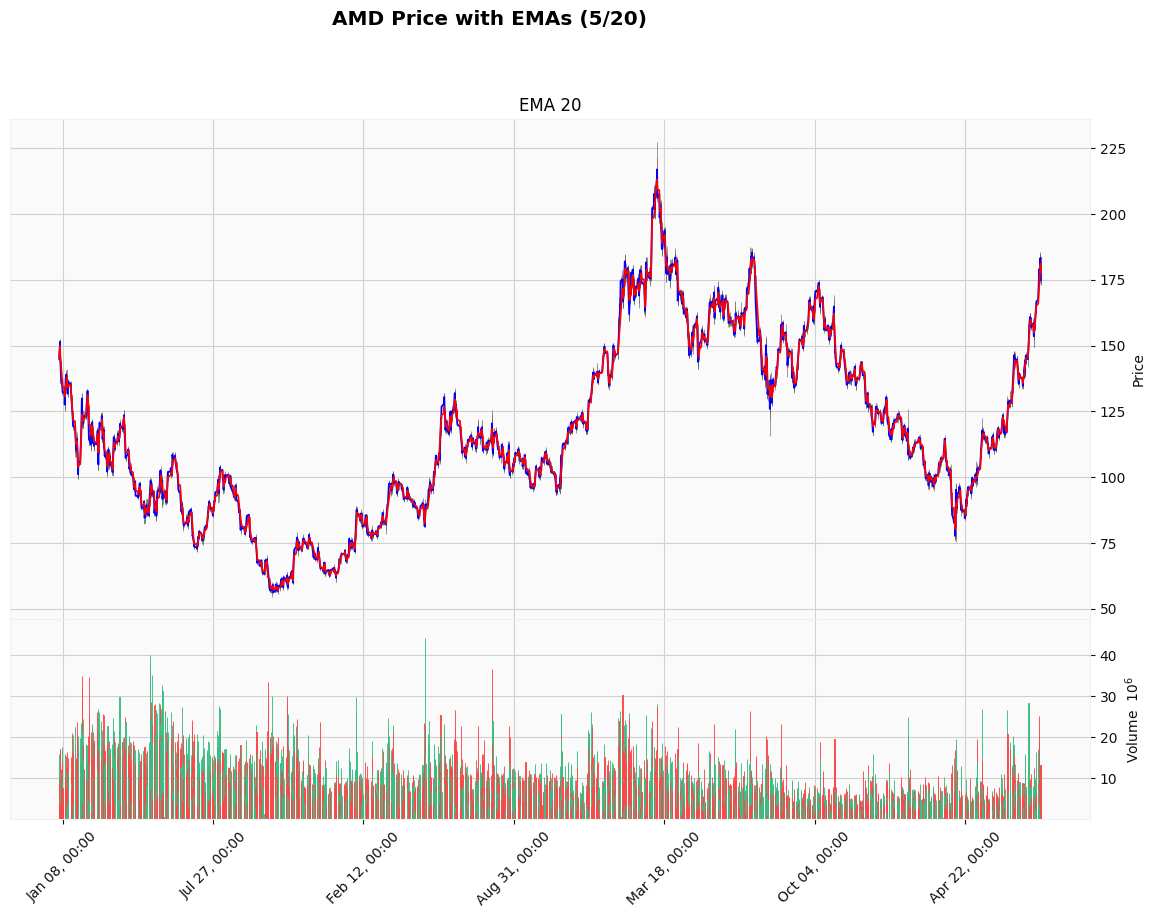

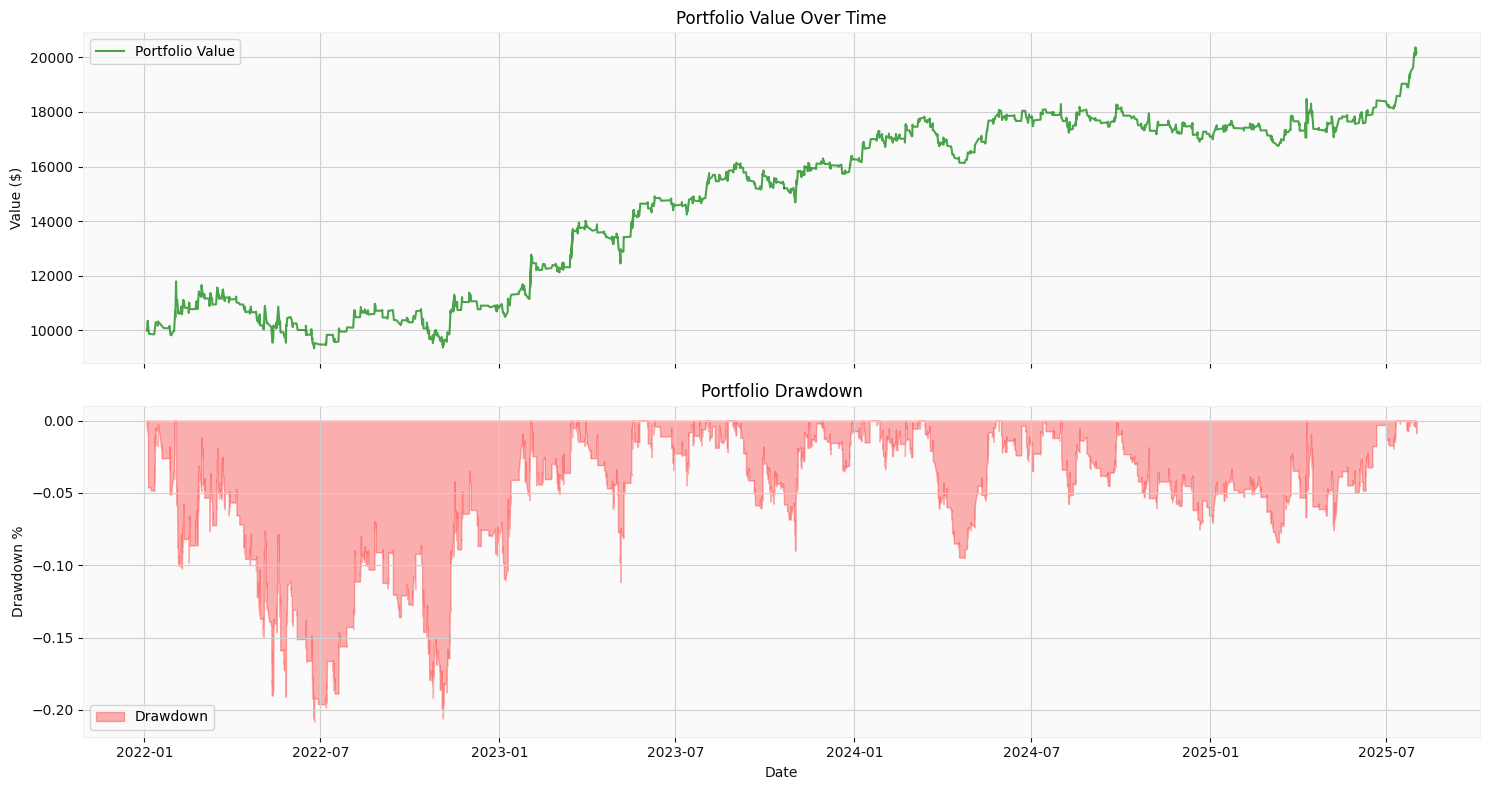

/Users/yush/Documents/GitHub/ema_backtest/.venv/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


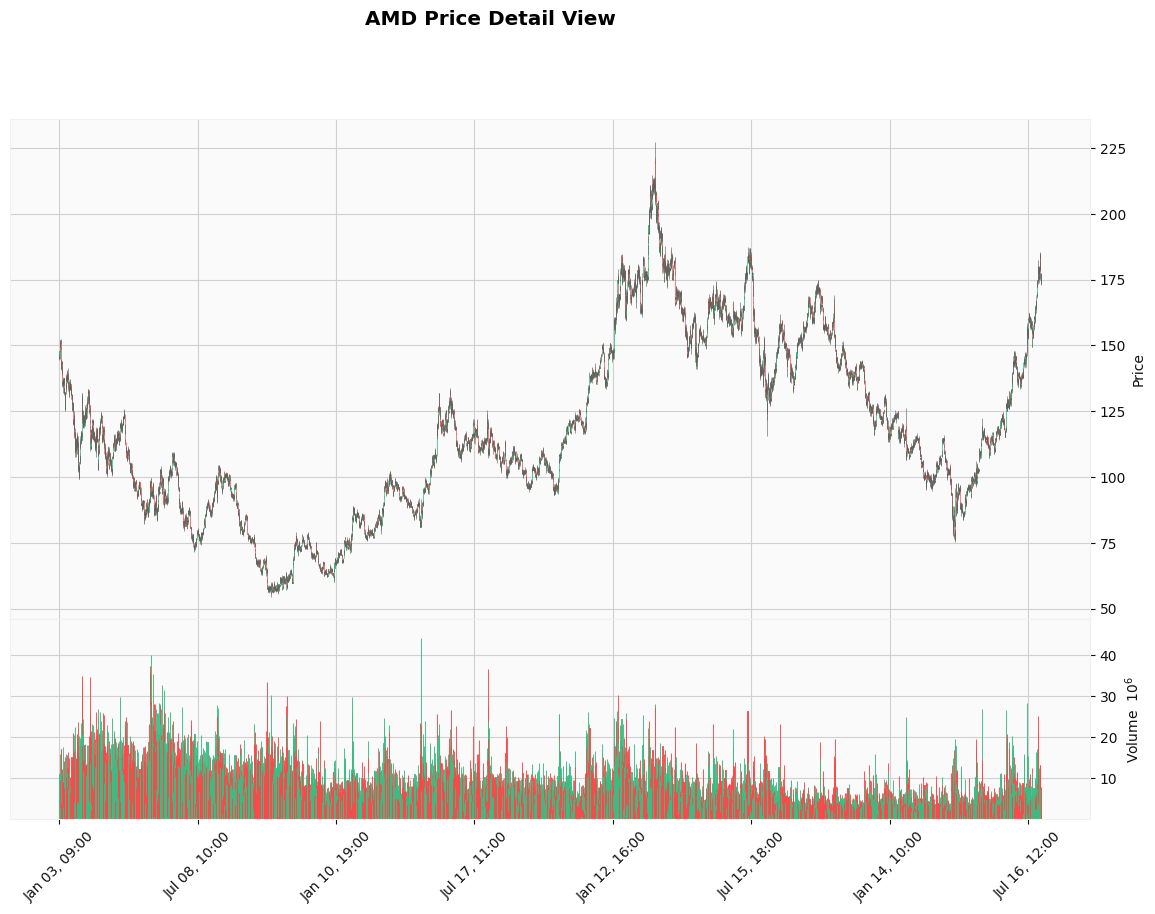

In [7]:
# Prepare the data for candlestick chart
ohlc_data = data.copy()
ohlc_data = ohlc_data.sort_index()

# Create the candlestick chart with EMAs using mplfinance
ap = [
    mpf.make_addplot(ohlc_data['EMA_short'], color='blue', title=f'EMA {EMA_SHORT_PERIOD}'),
    mpf.make_addplot(ohlc_data['EMA_long'], color='red', title=f'EMA {EMA_LONG_PERIOD}')
]

mpf.plot(
    ohlc_data,
    type='candle',
    style='yahoo',
    title=f'AMD Price with EMAs ({EMA_SHORT_PERIOD}/{EMA_LONG_PERIOD})',
    ylabel='Price',
    volume=True,
    addplot=ap,
    figsize=(15, 10),
    show_nontrading=True
)

# Plot Portfolio Value and Drawdown using matplotlib
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot 2: Portfolio Value
ax2.plot(portfolio.index, portfolio['total_value'], label='Portfolio Value', color='green', alpha=0.7)
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Value ($)')
ax2.legend()
ax2.grid(True)

# Plot 3: Drawdown
returns = portfolio['total_value'].pct_change()
cum_returns = (1 + returns).cumprod()
running_max = cum_returns.expanding().max()
drawdown = (cum_returns - running_max) / running_max
ax3.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
ax3.set_title('Portfolio Drawdown')
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown %')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Display additional chart with just price and volume (no overlays)
mpf.plot(
    ohlc_data,
    type='candle',
    title='AMD Price Detail View',
    ylabel='Price',
    volume=True,
    figsize=(15, 10),
    style='yahoo'
)